# [ICTCOG AI Academy] 7기 고급시각저녁반
# GAN(1)


### CVAE 복습

In [44]:
import tensorflow as tf

In [45]:
a=tf.constant([1,2,3])
type(a) #EagerTensor 

tensorflow.python.framework.ops.EagerTensor

eager tensor(즉시 실행해서 바로 정답을 알 수 있음)

In [47]:
tf.executing_eagerly() #True : eager tensor 기본적으로 으로 실행

True

- tf2, Pytorch에서 tf2, Pytorch에서 **eager tensor**은 script형식으로 결과를 하나 하나 확인 가능하나 compile 언어 보다 느림

In [48]:
tf.compat.v2.executing_eagerly 

<function tensorflow.python.eager.context.executing_eagerly>

In [49]:
tf.compat.v1.enable_eager_execution

<function tensorflow.python.framework.ops.enable_eager_execution>

### [tf.function](https://www.tensorflow.org/guide/function?hl=ko)
Just In Time(JIT)
- 스크립트 언어에서 사용할 부분만 내부적으로 compile해서 속도 향상하는 방법 
- > 무조건 속도를 높여주는 마법의 은총알이 아닙니다! 
  > - No Siver Bullet 은총알은 없다.
  > - No Free Lunch 공짜 점심은 없다
    - 절대적인 방법은 없다!

- Tensorflow 연산과 잘 작동함
- debugging 어려움

In [ ]:
@tf.function #decorator 사용해서속도 향상

함수형 패러다임!

결과값 상이함

In [ ]:
def add(a,b):
  return a+b

add([1,2],[3,4])

[1, 2, 3, 4]

In [ ]:
import numpy as np

In [ ]:
@np.vectorize
def add(a,b):
  return a+b

add([[1,2]],[[3,4]])

array([[4, 6]])

In [ ]:
@tf.function
def add(a,b):
  return a+b

add([1,2],[3,4]) #list 내 2개 데이터

[[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=2>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=3>,
  <tf.Tensor: shape=(), dtype=int32, numpy=4>]]

In [ ]:
add([[1,2]],[[3,4]]) #list 내 2개 데이터

[[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
  <tf.Tensor: shape=(), dtype=int32, numpy=2>],
 [<tf.Tensor: shape=(), dtype=int32, numpy=3>,
  <tf.Tensor: shape=(), dtype=int32, numpy=4>]]

In [ ]:
len(add([[1,2]],[[3,4]]))

2

In [ ]:
x=tf.constant([1,2])
y=tf.constant([3,4])

In [ ]:
a=np.array([1,2])
b=np.array([1,2])

In [ ]:
add(a,b) #numpy -> Tensor로 변환됨(resource $$$ )

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 4])>

In [ ]:
v=tf.Variable(1.0)

In [ ]:
with tf.GradientTape() as t:
  result=add(v,2.0)

In [ ]:
t.gradient(result,v)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

tf.function
1. tensor 함수로 변환됨
  - compile 방식으로 작동해서 성능 향상
2. 컨볼루션 연산과 같은 계산량이 많은 경우에는 속도 향상 크지 않음
  - 

In [ ]:
import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
  return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# 워밍 업
conv_layer(image); conv_fn(image)
print("즉시 실행 합성곱:", timeit.timeit(lambda: conv_layer(image), number=10))
print("tf.function 합성곱:", timeit.timeit(lambda: conv_fn(image), number=10))
print("합성곱 연산 속도에 큰 차이가 없습니다.")

즉시 실행 합성곱: 1.3019309920000524
tf.function 합성곱: 1.264036713999758
합성곱 연산 속도에 큰 차이가 없습니다.


디버깅 체크 어려우므로 즉시 실행모드에서 먼저 확인 후 적용

In [ ]:
tf.debugging.enable_check_numerics  #numerical stability 추적

#### 트레이싱과 다형성
- 메소드 오버로딩 지원
> 객체지향의 다형성
  - 오버로딩(메소드,함수) 
    - compile, static, early binding
  - 오버라이딩

- 실행순서를 통해 디버깅



In [ ]:
def f():
  print('트레이싱!')
  tf.print('실행')

tf.function(f)()
tf.function(f)()

트레이싱!
실행
트레이싱!
실행


- 콘크리트 함수를 딕셔너리 방식(키:값) 으로 캐싱
> 추상 클래스 `ABCMeta` 기법 사용


#### side effect
- 합수형 패러다임에서는 입력, 출력 제외한 모든 것
- tracing  동안에만 발생해서 안전하게 사용

In [ ]:
@tf.function
def f(x):
  print("트레이싱", x)
  tf.print("실행", x)

f(1)
f(1)
f(2)

트레이싱 1
실행 1
실행 1
트레이싱 2
실행 2


GPU, TPU에서 잘 작동 안하는 경우 있음

### [CVAE](https://www.tensorflow.org/tutorials/generative/cvae)


In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )
#속도 향상; 디버깅 불편
  @tf.function
  def sample(self, eps=None): #sampling 래덤하게 값 추출
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
 #reparameterize 
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

 #학습
@tf.function
def train_step(model, x, optimizer):
  
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape: #미분을 위해 필수
  #loss function을 미분, 값 모두 저장
    loss = compute_loss(model, x)
  #모델의 학습 파라미터
  gradients = tape.gradient(loss, model.trainable_variables)
  #다양한 gradient 방식 적용
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

상황에 따라서  gradient descent 하는 방식 상이 
-  tf.GradientTape : low level로 구현 

In [ ]:
with tf.GradientTape() as t:
  result=add(v,2.0)

gr=t.gradient(result,v)

In [ ]:
z=zip([1,2,3],[4,5,6])
 #순서대로 쌍으로 묵음음

(1, 4)

In [ ]:
from itertools import zip_longest

In [ ]:
z=zip_longest([1,2,3,4],[3,4,5])
list(z)                         #긴거 기준

[(1, 3), (2, 4), (3, 5), (4, None)]

In [ ]:
v=tf.Variable(1.0)

In [ ]:
op=tf.keras.optimizers.Adam()

In [ ]:
op.apply_gradients(zip(gr,v)) #adam optimizer적용

In [ ]:
op.apply_gradients(zip(gr,v)) #adam optimizer적용

TypeError: ignored

[전문가용](https://www.tensorflow.org/tutorials/quickstart/advanced)
- 학습에서의 가장 작은 단위를 조절

In [ ]:
@tf.function
def train_step(images, labels):  
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  #loss함수를 trainable_variables 대해서 미분 해서 최적의 값 찾기tf.function
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
fit
fit_generator
train_on_batch

In [50]:
model=tf.keras.models.Sequential([ 
                                  tf.keras.layers.Dense(1)      
])
model.compile(loss='mse')
model.fit(steps_per_epoch=10) #epcoh 당 스텝텝

gradient tape 사용하는 목적
- 학습 과정 


#### Automatic Differentiation in PyTorch
-  Pytorch에서 자동미분은 gradint Tape 사용하지 않음

#### Automatic Differentiation in ML
- Google 의 TensorFlow 에서는 gradient tape 방식 사용

> 프레임워크의 관점에 따라 상이하다!

---
### Annotation
- Detection labelling  Annotation tool: https://github.com/developer0hye/Yolo_label
- 알고리즘별로 데이터 포맷 상이하므로 유의

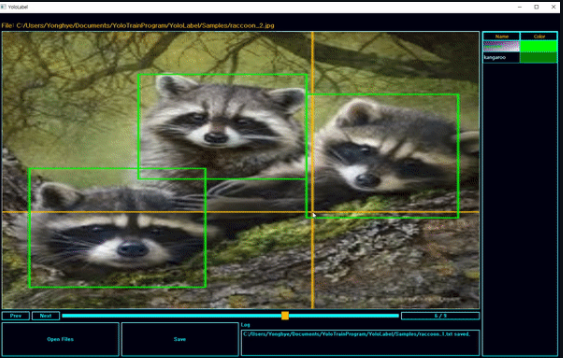

[keras VAE예시](https://keras.io/examples/generative/vae/)

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [54]:
latent_dim = 2
#multi-inputs,outputs

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
#평균,표준편차 기반으로 레이어 생성
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [55]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [57]:
class VAE(keras.Model): #모델 상속lass VAE(keras.Model): #모델 상속
  def __init__(self, encoder, decoder, **kwargs):
      super(VAE, self).__init__(**kwargs)
      self.encoder = encoder
      self.decoder = decoder
      self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
      self.reconstruction_loss_tracker = keras.metrics.Mean(
          name="reconstruction_loss"
      )
      self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]
#tf.function 사용하지 않음
  def train_step(self, data):
      with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(data)
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              tf.reduce_sum(
                  keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
              )
          )
          #복잡한 loss funciton
          kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
          total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      #tracking
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }

In [58]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 93s 168ms/step - loss: 250.8466 - reconstruction_loss: 203.3332 - kl_loss: 3.2451
Epoch 2/30
547/547 [==============================] - 91s 167ms/step - loss: 169.3147 - reconstruction_loss: 161.1922 - kl_loss: 4.8368
Epoch 3/30
547/547 [==============================] - 92s 167ms/step - loss: 160.7588 - reconstruction_loss: 154.2346 - kl_loss: 5.3724
Epoch 4/30
547/547 [==============================] - 91s 167ms/step - loss: 157.5007 - reconstruction_loss: 151.3214 - kl_loss: 5.6084
Epoch 5/30
547/547 [==============================] - 91s 166ms/step - loss: 155.4800 - reconstruction_loss: 149.4695 - kl_loss: 5.7572
Epoch 6/30
547/547 [==============================] - 92s 167ms/step - loss: 154.1776 - reconstruction_loss: 148.0750 - kl_loss: 5.8464
Epoch 7/30
547/547 [==============================] - 91s 167ms/step - loss: 152.9789 - reconstruction_loss: 147.1058 -

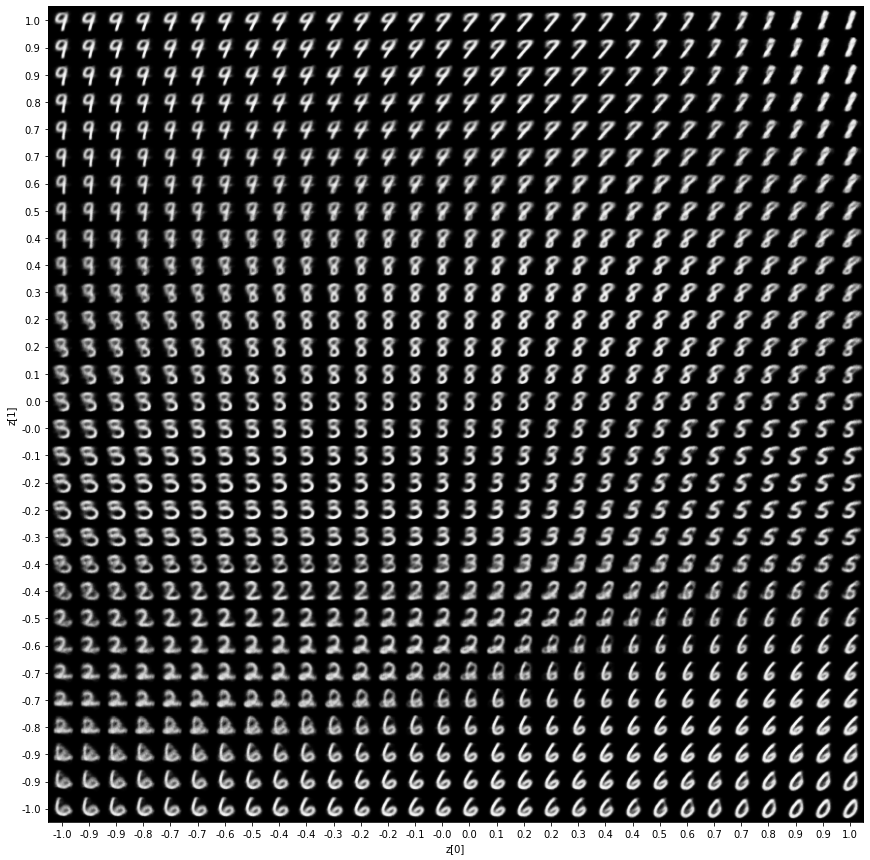

In [59]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

GAN에 비해 이미지가 선명하지 못함
---
### GAN(generative adversarial network)
- 비지도 학습
- 적대적 생성 모델
  - generative model 생성 모델: **분포기반**으로 생성
#### 적대적 경쟁
- 생성자 : 와인 위조범에게 피드백을 주어 가짜 술을 더 정교하게 만듦
- 식별자: 반대로 판별자도 학습하여 위조를 판별하는 능력을 향상

> 실수할 확률을 최소화하도록 능력을 극대화 시킴